# Toy model for UHECR track generation and classification

In [1]:
%matplotlib inline
from generate_sample_frames_angle import *
import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from matplotlib import pyplot as plt
from matplotlib import colors
import pickle
import time
import tensorflow as tf
import os, errno

C:\Users\Figge\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


genarated 360 frames of background
genarated 360 background labels
displaying a random sample of 10 frames: 


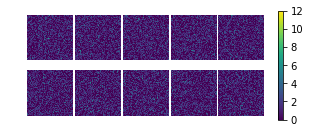

generated 360 frames of tracks
genarated 360 track labels
displaying a random sample of 10 frames: 


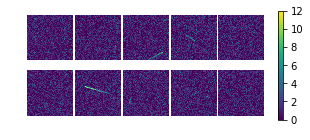

saved generated frames to file in samples/


In [2]:
# set up the TrackModel
track_model = TrackModel()
track_model.mu_c = 6 # mean track brightness
n_frame = 360
n_angle = 4 # number of angle categories

# generate sample background and tracks
with SampleGenerator(track_model) as generator:
    generator.background(n_frame, n_angle)
    generator.tracks(n_frame, n_angle)
    generator.save()

In [3]:
# Load background data
outfilename = 'samples/sample_generator_bg.dat'
with open(outfilename, 'rb') as f:
    data_bg = pickle.load(f)

outfilename = 'samples/sample_generator_track.dat'
with open(outfilename, 'rb') as f:
    data_track = pickle.load(f)

In [4]:
# Load track data
outfilename = 'samples/sample_generator_bg_labels.dat'
with open(outfilename, 'rb') as f:
    labels_bg = pickle.load(f)

outfilename = 'samples/sample_generator_track_labels.dat'
with open(outfilename, 'rb') as f:
    labels_track = pickle.load(f)

In [5]:
# Set up a norm for the plots
norm = generator.norm

Look at the first background image
this image has label:  [0. 0. 0. 0. 1.]


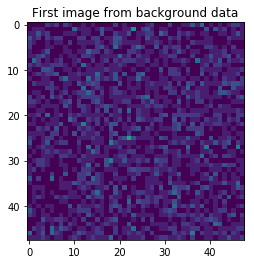

In [6]:
# Look at the first background image
plt.imshow(data_bg[0], norm=norm)
plt.title("First image from background data")

# and its label
print ("this image has label: ", labels_bg[0])

Look at the first track image
this image has label:  [1. 0. 0. 0. 0.]


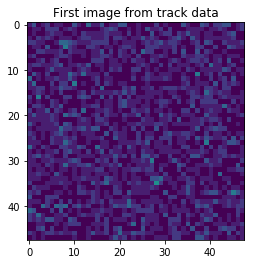

In [7]:
# Look at the first track image
plt.imshow(data_track[0], norm=norm)
plt.title("First image from track data")

# and its label
print ("this image has label: ", labels_track[0])

this image has label:  [0. 0. 0. 1. 0.]


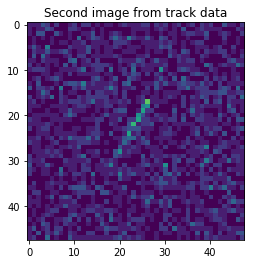

In [8]:
# Look at the second track image
plt.imshow(data_track[1], norm=norm)
plt.title("Second image from track data")

# and its label
print ("this image has label: ", labels_track[1])

this image has label:  [1. 0. 0. 0. 0.]


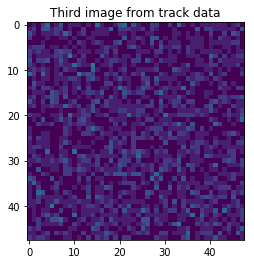

In [9]:
# Look at the third track image
plt.imshow(data_track[2], norm=norm)
plt.title("Third image from track data")

# and its label
print ("this image has label: ", labels_track[2])

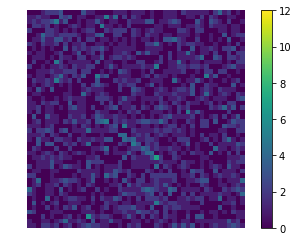

In [10]:
# Save a figure of a track frame, including a colorbar
fig, axs = plt.subplots(1, 1)

images_bg = []
images_track = []

for i in range(n_frame):
    
    images_bg.append(plt.imshow(data_bg[i]))
    images_track.append(plt.imshow(data_track[i]))

for im in images_bg:
    im.set_norm(norm)
    
for im in images_track:
    im.set_norm(norm)
    
fig.colorbar(images_bg[1], ax=axs, orientation='vertical', fraction=.1)
plt.axis('off')
plt.imshow(data_track[3], norm=norm)
#plt.savefig('fig.eps', format='eps', dpi=400) # save figure

In [11]:
# Reshape and shuffle the data
data = np.concatenate([data_bg, data_track])
data = np.reshape(data, (2*n_frame, 48, 48, 1))

labels = np.concatenate([labels_bg, labels_track])

data, labels = shuffle(data, labels)

validation_ratio = 1/5
index = int(1 - validation_ratio*np.shape(data)[0]/2)-1
# should be index = int(1 - 1/((1/(validation_ratio+1)))*np.shape(data)[0]/2)-1

data_test = data[index:]
labels_test = labels[index:]

data = data[0:index]
labels = labels[0:index]

In [12]:
# Callback class for keeping track of best accuracy and loss
class MonitorCallback(tflearn.callbacks.Callback):
    def __init__(self):
        self.best_acc = 0
        self.best_loss = 10
        self.best_params = None
        self.best_val_acc_epoch = None
        self.best_loss_epoch = None
    
    def on_epoch_end(self, training_state, snapshot=False):
        if training_state.val_acc > self.best_acc:
            self.best_acc = training_state.val_acc
            self.best_val_acc_epoch = training_state.epoch
            
        if training_state.global_loss < self.best_loss:
            self.best_loss = training_state.global_loss
            self.best_loss_epoch = training_state.epoch
        
    def getBestValAccEpoch(self):
        return self.best_val_acc_epoch
        
    def getBestLossEpoch(self):
        return self.best_loss_epoch
        
    def getBestValAcc(self):
        return self.best_acc 
        
    def getBestLoss(self):
        return self.best_loss
    
monitorCallback = MonitorCallback()

In [13]:
# Callback class for visualizing convolutional filters
class PlottingCallback(tflearn.callbacks.Callback):
    def __init__(self, model, x,
                 layer_to_observe,
                 kernels,
                 inputs=1):
        self.model = model
        self.x = x
        self.kernels = kernels
        self.inputs = inputs
        #self.observers = [tflearn.DNN(l) for l in layers_to_observe]
        self.observers = tflearn.DNN(layer_to_observe)
        
        if not os.path.exists("images"):
            os.makedirs("images")

    def on_epoch_end(self, training_state):
        outputs = [self.observers.predict(self.x)]

        for i in range(self.inputs):
            plt.figure(frameon=False)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            ix = 1
            for o in outputs:
                for kernel in range(self.kernels):
                    plt.subplot(len(outputs), self.kernels, ix)
                    plt.imshow(o[i, :, :, kernel])
                    plt.axis('off')
                    ix += 1
            plt.savefig('images/outputs-for-image%i-at-epoch%i.png'
                        % (i, training_state.epoch))

In [14]:
# Callback class for saving accuracy and loss to a file
class DataSaveCallback(tflearn.callbacks.Callback):
    def __init__(self):
        self.g = open("val_acc.txt","w+")
        self.h = open("loss.txt","w+")
    def on_epoch_end(self, training_state, snapshot=False):
        g = open("val_acc.txt", "a+")
        g.write(str(training_state.epoch))
        g.write(" ")
        g.write(str(training_state.val_acc))
        g.write("\n")
        
        h = open("loss.txt", "a+")
        h.write(str(training_state.epoch))
        h.write(" ")
        h.write(str(training_state.global_loss))
        h.write("\n")

In [15]:
start_time = time.time()

# Define the network architecture:

# Input is a 48x48 image with 1 "color" channel
network = input_data(shape=[None, 48, 48, 1])

# Step 1: Convolution
conv_1 = conv_2d(network, 16, 3, activation='relu', name='conv1')

# Step 2: Max pooling
network = max_pool_2d(conv_1, 2)

# Step 3: Convolution again
network = conv_2d(network, 64, 3, activation='relu', name='conv2')

# Step 4: Max pooling again
network = max_pool_2d(network, 2)

# Step 5: Convolution yet again
conv_3 = conv_2d(network, 16, 3, activation='relu', name='conv3')

# Step 6: Max pooling yet again
network = max_pool_2d(conv_3, 2)

# Step 7: Fully connected 128 node neural network
network = fully_connected(network, 128, activation='relu', name='fc1')

# Step 8: Dropout - throw away some data randomly during training to prevent overfitting
network = dropout(network, 0.5)

# Step 9: Fully-connected neural network with n_angle+1 outputs
network = fully_connected(network, n_angle+1, activation='softmax')

# Tell tflearn how to train the network
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.001)

# Wrap the network in a model object
model = tflearn.DNN(network, tensorboard_verbose=0)

# Train it
model.fit(data, labels, n_epoch=50, shuffle=True, validation_set=(data_test, labels_test),
          show_metric=True, batch_size=64,
          #snapshot_epoch=True,
          run_id='track-classifier',
          #callbacks=[MonitorCallback(), PlottingCallback(model, data_test, conv_3, 16), DataSaveCallback()])
          callbacks = [monitorCallback, DataSaveCallback()])

# Save model when training is complete to a file
model.save("track-classifier.tfl")

end_time = time.time()

elapsed_time = end_time - start_time

print("Network trained and saved as track-classifier.tfl!")
print("The training took: ", elapsed_time)

Training Step: 257  | total loss: 1.26368 | time: 0.246s
| Adam | epoch: 024 | loss: 1.26368 - acc: 0.5703 -- iter: 256/648


KeyboardInterrupt: 

In [ ]:
print('Best validation accuracy:', monitorCallback.getBestValAcc())
print('Achieved by the end of epoch', monitorCallback.getBestValAccEpoch())
print('')
print('Best loss:', monitorCallback.getBestLoss())
print('Achieved by the end of epoch', monitorCallback.getBestLossEpoch())